# Импорты

In [6]:
import pandas as pd
import numpy as np
import sklearn
from pathlib import Path

## Дефолтные настройки Matplotlib

In [7]:
import matplotlib.pyplot as plt

# устанавливаем дефолтные размеры шрифтов
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Загрузка датасета

In [8]:
def load_data(path: Path):
    print("Read data set from path {path}".format(path=path))
    df = pd.read_csv(path)
    df["constraint1"] = df["constraint1"].astype('bool')
    df["constraint2"] = df["constraint2"].astype('bool')
    return df

Непосредственно загрузка

In [9]:
data_1_path = Path("data/DataSet900.csv")
data_2_path = Path("data/DataSet1000.csv")
data_3_path = Path("data/DataSet100000.csv")
data_4_path = Path("data/DataSet129600.csv")

data_1 = load_data(data_1_path)
data_2 = load_data(data_2_path)
data_3 = load_data(data_3_path)
data_4 = load_data(data_4_path)

dataset = data_1

Read data set from path data\DataSet900.csv
Read data set from path data\DataSet1000.csv
Read data set from path data\DataSet100000.csv
Read data set from path data\DataSet129600.csv


Шапка датасета, первые 5 записей  набора данных.

In [10]:
dataset.head()

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2
0,10,10,20,0.000,True,False
1,10,13,23,216.770,True,True
2,10,16,26,490.088,True,True
3,10,19,29,819.956,False,True
4,10,22,32,1206.370,False,True


Информация по колонкам

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   parameter1   900 non-null    int64  
 1   parameter2   900 non-null    int64  
 2   criteria1    900 non-null    int64  
 3   criteria2    900 non-null    float64
 4   constraint1  900 non-null    bool   
 5   constraint2  900 non-null    bool   
dtypes: bool(2), float64(1), int64(3)
memory usage: 30.0 KB


Основная статистическая информация по колонкам 

In [12]:
dataset.describe()

,parameter1,parameter2,criteria1,criteria2
count,900.000000,900.000000,900.000000,900.000000
mean,53.500000,53.500000,107.000000,0.000000
std,25.980762,25.980762,36.742346,12637.603925
min,10.000000,10.000000,20.000000,-29245.100000
25%,31.000000,31.000000,80.000000,-8574.190000
50%,53.500000,53.500000,107.000000,0.000000
75%,76.000000,76.000000,134.000000,8574.190000
max,97.000000,97.000000,194.000000,29245.100000


Количество встречающихся значений `constraint1`

In [13]:
dataset["constraint1"].value_counts()

constraint1
True     662
False    238
Name: count, dtype: int64

Количество встречающихся значений `constraint2`

In [14]:
dataset["constraint2"].value_counts()

constraint2
False    465
True     435
Name: count, dtype: int64

Код описывающий сохранение графиков и рисунков

In [15]:
IMAGES_PATH = Path() / "imgs"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Представление о данных.
- по вертикали количество повторений
- по горизонтали величина значений

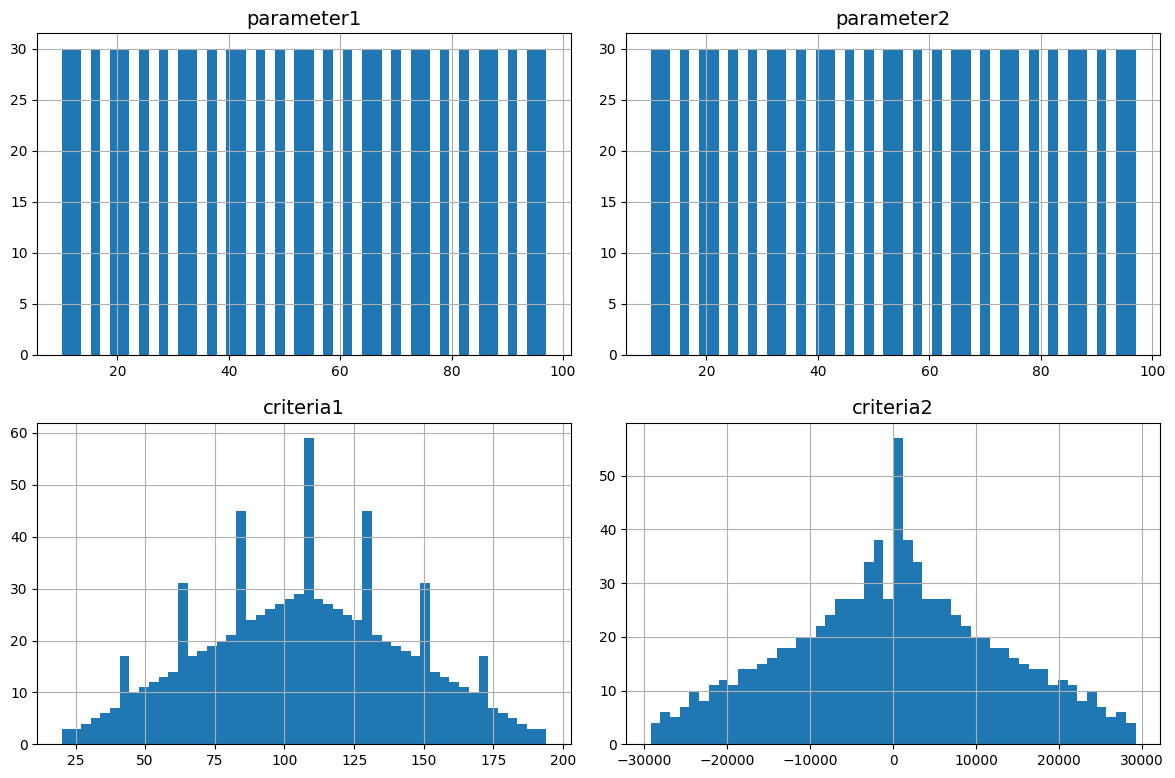

In [16]:
dataset.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

Устанавливаем параметр рандомизации (что бы значения повторялись при запуске)

In [17]:
np.random.seed(30)

# Тренировочный датасет

In [18]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=30)

# Тренировочный датасет

In [19]:
train_data = train_set.copy()
test_data = test_set.copy()

In [20]:
test_data.head(5)

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2
624,70,82,152,5730.27,True,True
245,34,25,59,-1668.19,True,False
100,19,40,59,3892.43,False,True
800,88,70,158,-8934.69,True,False
875,97,25,122,-27595.70,True,False


## Корреляция параметров

In [21]:
corr_matrix = train_data.corr()
corr_matrix

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2
parameter1,1.000000,-0.014805,0.699238,-0.696664,0.645349,-0.582837
parameter2,-0.014805,1.000000,0.704458,0.695963,-0.407654,0.584678
criteria1,0.699238,0.704458,1.000000,0.003082,0.166625,0.004314
criteria2,-0.696664,0.695963,0.003082,1.000000,-0.685381,0.799010
constraint1,0.645349,-0.407654,0.166625,-0.685381,1.000000,-0.627427
constraint2,-0.582837,0.584678,0.004314,0.799010,-0.627427,1.000000


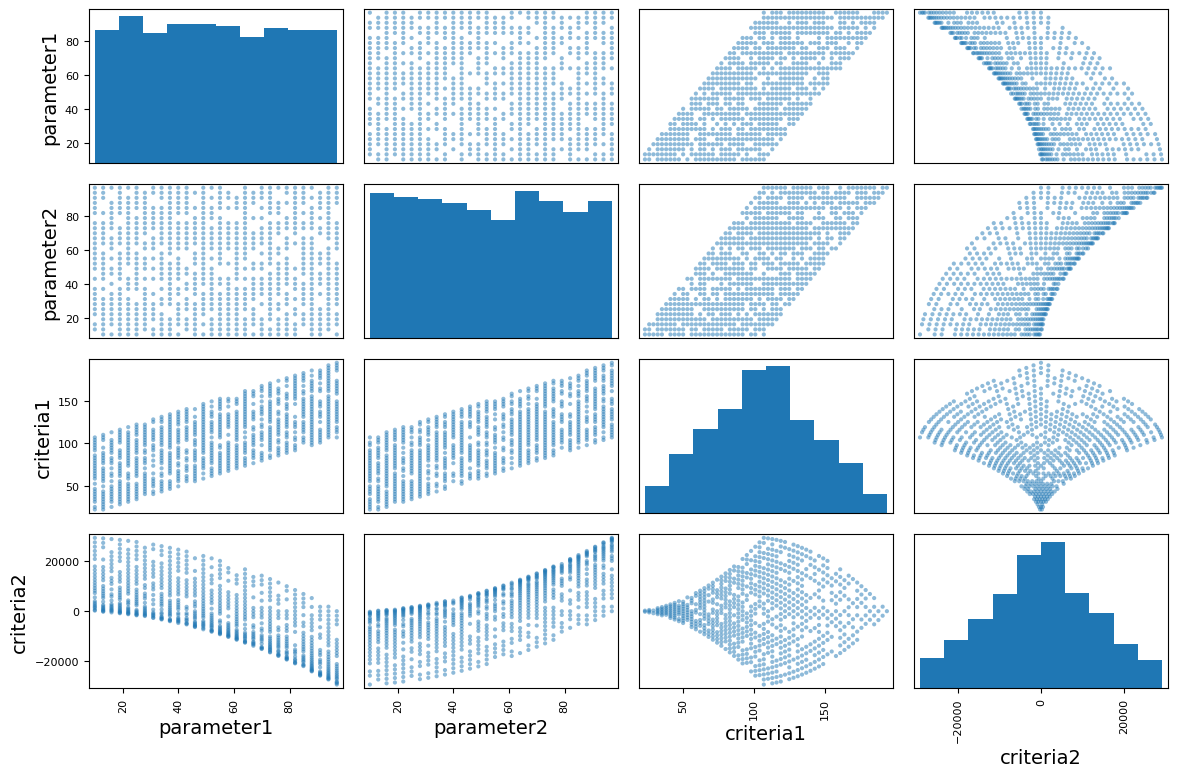

In [22]:
from pandas.plotting import scatter_matrix

attributes = ["parameter1", "parameter2", "criteria1",
              "criteria2"]
scatter_matrix(train_data[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

## Эксперименты с атрибутами

In [23]:
train_data["criteria2_parameter1"] = train_data["criteria2"] / train_data["parameter1"]
train_data["criteria2_parameter2"] = train_data["criteria2"] / train_data["parameter2"]
train_data["parameter1_parameter2"] = train_data["parameter1"] * train_data["parameter2"]

corr_matrix = train_data.corr()
corr_matrix["criteria1"].sort_values(ascending=False)

criteria1                1.000000
parameter1_parameter2    0.943780
parameter2               0.704458
parameter1               0.699238
constraint1              0.166625
criteria2_parameter2     0.064424
constraint2              0.004314
criteria2                0.003082
criteria2_parameter1    -0.052373
Name: criteria1, dtype: float64

Новый критерий сильно коррелирует с нашим параметром

# Общие функции

Описание модели обучения

In [24]:
import pickle
import select

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


class MyModel():
    def  __init__(self,
                  data:pd.DataFrame,
                  features: list,
                  predict_label_name: str,
                  model):
        self.data = data
        self.features = features
        self.predict_label_name = predict_label_name
        self.model: LinearRegression = model
        
        self.split_data()
    
    def split_data(self):
        self.train_data, self.test_data = train_test_split(
            self.data, test_size=0.95, random_state=30)
        
        self.train_data_values = self.train_data[self.features]
        self.train_data_labels = self.train_data[self.predict_label_name]
        
        self.test_data_values = self.test_data[self.features]
        self.test_data_labels = self.test_data[self.predict_label_name]
    
    def fit(self):
        self.model = self.model.fit(self.train_data_values, self.train_data_labels)
    
    def get_predict(self):
        return self.model.predict(self.test_data_values)
    
    def get_test_labels(self):
        return self.test_data_labels 
    
    def get_model(self):   
        return self.model

    def save_model(self):
        name = '_'.join(self.features+[self.predict_label_name])
        pkl_filename = "saved_model/"+name+".pkl" 
        with open(pkl_filename, 'wb') as file: 
            pickle.dump(self.model, file) 
    
    def load_model(self, pkl_filename):
        with open(pkl_filename, 'rb') as file: 
            self.model = pickle.load(file)
        
                

# Подготовка датасета

In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   parameter1   900 non-null    int64  
 1   parameter2   900 non-null    int64  
 2   criteria1    900 non-null    int64  
 3   criteria2    900 non-null    float64
 4   constraint1  900 non-null    bool   
 5   constraint2  900 non-null    bool   
dtypes: bool(2), float64(1), int64(3)
memory usage: 30.0 KB


# Создаём модели и обучаем

In [26]:
from typing import List
from copy import deepcopy

from sklearn.linear_model import (
    LinearRegression, 
    SGDRegressor,
    SGDClassifier
) 
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor
)
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score, 
    mean_squared_log_error,
)
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model



принцип именования сначала критерий который нужно предсказать, следом параметры по которым обучается модель

In [27]:
def MSE_metric(parameters_list, model, data):
    models: List[MyModel] = []
    for parameters in parameters_list:
        models.append(
            MyModel(
                data=data,
                features=parameters[0],
                predict_label_name=parameters[1],
                model=deepcopy(model),
            )
        )
    
    for model in models:
        print('''
              ***************************************''')
        print("Begin predict {} from {}".format(model.predict_label_name,
                                               '_'.join(model.features)))
        model.fit()
        
        predict = model.get_predict()
        print('Predict:', predict[:6])
        labels = model.get_test_labels()
        print('Test:', labels[:6].tolist())
        score = mean_squared_error(
            labels,
            predict,
            squared=False
        )        
        print("Score MSE {}".format(score))
        model.save_model()
  
    
calculation_list_1 = [
    [['parameter1', 'parameter2'], 'criteria1'],
    [['parameter1', 'parameter2'], 'criteria2'],
    [['criteria1', 'criteria2'], 'parameter1'],
    [['criteria1', 'criteria2'], 'parameter2'],
    [['criteria1', 'criteria2', 'constraint1', 'constraint2'], 'parameter1'],
    [['criteria1', 'criteria2', 'constraint1', 'constraint2'], 'parameter2'],
]

In [28]:
def AC_metric(parameters_list, model, data):
    models: List[MyModel] = []
    for parameters in parameters_list:
        models.append(
            MyModel(
                data=data,
                features=parameters[0],
                predict_label_name=parameters[1],
                model=deepcopy(model),
            )
        )
    
    for model in models:
        print('''
              ***************************************''')
        print("Begin predict {} from {}".format(model.predict_label_name,
                                               '_'.join(model.features)))
        model.fit()
        ml_model = model.get_model()
        predict = model.get_predict()
        # print('Predict:', predict[:6])
        labels = model.get_test_labels()
        # print('Test:', labels[:6].tolist())
        
        score = accuracy_score(
            predict,
            labels
        )
        print("Score CVS {}".format(score))
        
calculation_list_2 = [  
    [['criteria1', 'criteria2'], 'constraint1'],
    [['criteria1', 'criteria2'], 'constraint2'],
    [['parameter1', 'parameter2'], 'constraint1'],
    [['parameter1', 'parameter2'], 'constraint2'],
    [['criteria1', 'criteria2', 'parameter1', 'parameter2'], 'constraint1'],
    [['criteria1', 'criteria2', 'parameter1', 'parameter2'], 'constraint2'],
]

# Метрика СКО
принцип именования сначала критерий который нужно предсказать, следом параметры по которым обучается модель

Модель обучения  - лес регрессии.

In [29]:
random_forest_model_regressor = RandomForestRegressor()
SGD_model = SGDRegressor()
linear_regression_model = LinearRegression()

print('Next random_forest_model_regressor >>>>>>>>>>>>>>>>>>>>>>')
MSE_metric(calculation_list_1, random_forest_model_regressor, dataset)

# print('Next linear_regression_model >>>>>>>>>>>>>>>>>>>>>>')
# MSE_metric(calculation_list_1, linear_regression_model, dataset)

# print('Next SGD_model >>>>>>>>>>>>>>>>>>>>>>')
# MSE_metric(calculation_list_1, SGD_model, dataset)

Next random_forest_model_regressor >>>>>>>>>>>>>>>>>>>>>>

              ***************************************
Begin predict criteria1 from parameter1_parameter2
Predict: [155.54  65.15  65.81 160.82 115.16 169.01]
Test: [152, 59, 59, 158, 122, 173]
Score MSE 7.351713226753411

              ***************************************
Begin predict criteria2 from parameter1_parameter2
Predict: [  6506.3012    203.4806   2735.5403  -7752.5322 -24095.952   -5421.9816]
Test: [5730.27, -1668.19, 3892.43, -8934.69, -27595.7, -4891.46]
Score MSE 1921.3859824269875

              ***************************************
Begin predict parameter1 from criteria1_criteria2
Predict: [66.61 37.87 24.76 83.65 93.34 84.07]
Test: [70, 34, 19, 88, 97, 91]
Score MSE 6.687958385667562

              ***************************************
Begin predict parameter2 from criteria1_criteria2
Predict: [78.04 27.73 42.1  63.7  32.56 77.8 ]
Test: [82, 25, 40, 70, 25, 82]
Score MSE 5.52193349051618

              *

# Простая метрика
Модель обучения  - лес классификации.

In [30]:
random_forest_model_classifier = RandomForestClassifier()
SGD_model = SGDClassifier()

print('Next random_forest_model_classifier >>>>>>>>>>>>>>>>>>>>>>')
AC_metric(calculation_list_2, random_forest_model_classifier, dataset)

# print('Next SGD_model >>>>>>>>>>>>>>>>>>>>>>')
# AC_metric(calculation_list_2, SGD_model, dataset)

Next random_forest_model_classifier >>>>>>>>>>>>>>>>>>>>>>

              ***************************************
Begin predict constraint1 from criteria1_criteria2
Score CVS 0.9345029239766082

              ***************************************
Begin predict constraint2 from criteria1_criteria2
Score CVS 0.9929824561403509

              ***************************************
Begin predict constraint1 from parameter1_parameter2
Score CVS 0.9192982456140351

              ***************************************
Begin predict constraint2 from parameter1_parameter2
Score CVS 0.9239766081871345

              ***************************************
Begin predict constraint1 from criteria1_criteria2_parameter1_parameter2
Score CVS 0.935672514619883

              ***************************************
Begin predict constraint2 from criteria1_criteria2_parameter1_parameter2
Score CVS 0.9906432748538012


# Вывод:
Результаты говорят что прогнозирование constraint1 и constraint2 весьма просто, так как там бинарный предикт. Остальные значения тоже можно прогнозировать однако с некоторой ошибкой, можно настроить гипперпараметры и тогда возможно результат улучшится.

# Применение нейронных сетей

In [31]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# Working with data

In [32]:
class MyDataset(Dataset):
    def __init__(self, 
                 data:pd.DataFrame,
                 input_colums: List[str],
                 output_colums: List[str]) -> None:
        self.input_colums = input_colums
        self.output_colums = output_colums
        
        x = data[self.input_colums].values
        y = data[self.output_colums].values
        
        self.x_train = torch.tensor(x, dtype=torch.float32)
        self.y_train = torch.tensor(y, dtype=torch.float32)      
        
    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index]   

# Creating Models

In [33]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, inputs, outputs, middle_layers=128):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(            
            nn.Linear(inputs, middle_layers),
            nn.ReLU(),
            nn.Linear(middle_layers, middle_layers),
            nn.ReLU(),
            nn.Linear(middle_layers, outputs)
        )

    def forward(self, x: torch.Tensor):
        logits = self.linear_relu_stack(x)
        return logits

test = NeuralNetwork(2,2).to(device)
print(test)

Using cpu device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


# Optimizing the Model Parameters

In [34]:
from numpy import mean
from torch.nn import MSELoss
from torch.optim import SGD

from sklearn.model_selection import train_test_split


class Trainer():
    
    def __init__(self,
                 data: pd.DataFrame,
                 input_colums: List[str],
                 output_colums: List[str],
                 batch_size=32,
                 learning_rate=0.005,
                 shuffle=False,
                 test_size=0.2,
                 random_state=None,
                 save_path='saved_model/model_weights.pth'):
        
        self.save_path = save_path
        
        self.input_colums = input_colums
        self.output_colums = output_colums
        
        self.normalize_param = {}
        self._normalize_data(data, input_colums+output_colums)       

        train_set, test_set = train_test_split(dataset, test_size=test_size, random_state=random_state)
                
        self.train_dataloader = DataLoader(
            MyDataset(train_set, input_colums, output_colums),
            batch_size=batch_size,
            shuffle=shuffle
        )
        self.test_dataloader = DataLoader(
            MyDataset(test_set, input_colums, output_colums),
            batch_size=batch_size,
            shuffle=False
        )
        
        self.model = NeuralNetwork(
            inputs=len(input_colums),
            outputs=len(output_colums),
            middle_layers=512
        ).to(device)
        
        self.loss_func = MSELoss()
        self.optimizer = SGD(self.model.parameters(), lr=learning_rate)       
    
    def train(self):
        size = len(self.train_dataloader.dataset)
        self.model.train()
        for batch, (X, y) in enumerate(self.train_dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = self.model(X)
            loss: torch.Tensor = self.loss_func(pred, y)

            # Backpropagation
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            if batch % 10 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                
    def test(self):
        num_batches = len(self.test_dataloader)
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for X, y in self.test_dataloader:
                X, y = X.to(device), y.to(device)
                pred = self.model(X)
                test_loss += self.loss_func(pred, y).item()
        test_loss /= num_batches
        print(f"Test Error: Avg loss: {test_loss:>8f} \n")
        
    def run(self,  epochs=10):
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            self.train()
            self.test()
        print("Done!")
    
    def predict(self, input: np.array):
        print('Входные данные', input)
        for index, item in enumerate(self.input_colums):
            input[index] = (input[index] - self.normalize_param[item]['mean']) /\
                self.normalize_param[item]['std']
        print('Нормализованные', input)
        pred:torch.Tensor = self.model(torch.tensor(input, dtype=torch.float32))        
        pred = pred.detach().numpy()
        print('Предикт модели', pred)
        for index, item in enumerate(self.output_colums):
            # pred[index] = pred[index] * self.normalize_param[item]['lenght']
            pred[index] = pred[index] * self.normalize_param[item]['std'] +\
                self.normalize_param[item]['mean']
        print('Денормализованные данные', pred)
        return pred
        
    
    def _normalize(self,
                   data: pd.DataFrame,
                   colum: str) -> torch.Tensor:
        mean = data[colum].mean()
        std = data[colum].std()
        data[colum] = (data[colum] - mean) / std  
        return {'mean': mean, 'std': std}
        # lenght = data[colum].max() - data[colum].min()
        # data[colum] = data[colum] / lenght
        # return {'lenght': lenght}
    
    def save_model(self):
        torch.save(self.model, self.save_path)       
    
    def _normalize_data(self, data, colums):
        for colum in colums:
            self.normalize_param[colum] = self._normalize(data, colum)
    
    def _denormalize(self, tensor, mean, std) -> torch.Tensor:
        return tensor * std

In [35]:
dataset = data_1.copy()
    
trainer = Trainer(
    data=dataset,
    input_colums=['criteria1', 'criteria2'],
    output_colums=['parameter1', 'parameter2'],
    batch_size=60,
    learning_rate=0.001,
    random_state=30
)

trainer.run(15)

Epoch 1
-------------------------------
loss: 1.039490  [   60/  720]
loss: 0.792363  [  660/  720]
Test Error: Avg loss: 0.865023 

Epoch 2
-------------------------------
loss: 0.878168  [   60/  720]
loss: 0.655835  [  660/  720]
Test Error: Avg loss: 0.719919 

Epoch 3
-------------------------------
loss: 0.743369  [   60/  720]
loss: 0.543603  [  660/  720]
Test Error: Avg loss: 0.599929 

Epoch 4
-------------------------------
loss: 0.629135  [   60/  720]
loss: 0.450387  [  660/  720]
Test Error: Avg loss: 0.499738 

Epoch 5
-------------------------------
loss: 0.531627  [   60/  720]
loss: 0.372572  [  660/  720]
Test Error: Avg loss: 0.415730 

Epoch 6
-------------------------------
loss: 0.448153  [   60/  720]
loss: 0.307639  [  660/  720]
Test Error: Avg loss: 0.345227 

Epoch 7
-------------------------------
loss: 0.376844  [   60/  720]
loss: 0.253436  [  660/  720]
Test Error: Avg loss: 0.286123 

Epoch 8
-------------------------------
loss: 0.316015  [   60/  720]

In [36]:
test_data[127:130]

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2
38,13,34,47,3100.75,False,True
539,61,97,158,17869.40,True,True
819,91,37,128,-21714.70,True,False


# Визуальное сравнение
Таблица сверху тестовые данные, снизу можно оценить примерную точность, взять значения из criteria1	criteria2 и получатся параметры parameter1	parameter2

In [37]:
trainer.predict(np.array([152,	5730.27]))


Входные данные [ 152.   5730.27]
Нормализованные [1.22474487 0.4534301 ]
Предикт модели [0.4767757 0.8625882]
Денормализованные данные [65.88699 75.9107 ]


array([65.88699, 75.9107 ], dtype=float32)

In [38]:
trainer.predict(np.array([155, -13147.60]))

Входные данные [   155.  -13147.6]
Нормализованные [ 1.30639453 -1.04035544]
Предикт модели [1.3019128  0.15516947]
Денормализованные данные [87.324684 57.53142 ]


array([87.324684, 57.53142 ], dtype=float32)

In [41]:
type(trainer.predict(np.array([47,	3100.75])))

Входные данные [  47.   3100.75]
Нормализованные [-1.63299316  0.24535901]
Предикт модели [-0.97351545 -0.7454758 ]
Денормализованные данные [28.207327 34.13197 ]


numpy.ndarray

## Best result
Test Error: Avg loss: 0.001735 

learning rate 0.0005

Epoch = 10000

batch_size = 120

# Save model

In [40]:
trainer.save_model()


# Load  model